In [1]:
import sys

sys.path.insert(0, "../")

In [2]:
%load_ext autoreload
%autoreload 2

# Post-processing TNG50 cosmological simulations with the PRFM theory

This example utilizes the post-prcessed TNG50 galaxy catalogs presented in [Hassan et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240909121H) as part of the [Learning the Universe collaboration](http://learning-the-universe.org). The original paper, code, and data can be found in the following links. For full analysis, one has to download the data in the [link](https://drive.google.com/drive/folders/1dsk6z7ugOJEedwfW6uhaDi8YYGvfPEF9?usp=sharing), but in this example notebook, we utilize a reduced data stroed in this repository.

* Paper: https://ui.adsabs.harvard.edu/abs/2024arXiv240909121H
* Code: https://github.com/sultan-hassan/tng50-post-processing-prfm
* Data: https://drive.google.com/drive/folders/1dsk6z7ugOJEedwfW6uhaDi8YYGvfPEF9?usp=sharing


In [3]:
import prfm
import numpy as np
import astropy.units as au
import astropy.constants as ac
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Reproduce examples as shown in [the data release repository](https://github.com/sultan-hassan/tng50-post-processing-prfm)

### Helper functions and constants

In [4]:
# constants and conversion factors
G = ac.G.to("kpc*M_sun-1*km2*s-2").value
pc_per_cm = ac.pc.cgs.value
Msun_per_gram = ac.M_sun.cgs.value
Year_per_sec = (1 * au.yr).cgs.value
kB = ac.k_B.cgs.value


def solve_cubic(a2, a1, a0):
    """
    Solves the cubic equation of the form: x^3 + a2*x^2 + a1*x + a0 = 0.

    Parameters:
    a2 (float): Coefficient of x^2.
    a1 (float): Coefficient of x.
    a0 (float): Constant term.

    Returns:
    tuple: Three real roots of the cubic equation.
    """

    # Calculate the reduced coefficients
    p = (3 * a1 - a2**2) / 3  # Depressed cubic's linear coefficient
    q = (9 * a1 * a2 - 27 * a0 - 2 * a2**3) / 27  # Depressed cubic's constant term

    # Intermediate terms for solving the cubic equation
    Q = p / 3
    R = q / 2
    discriminant = Q**3 + R**2  # Discriminant of the cubic equation

    # Calculate the angle theta for real root solutions
    theta = np.arccos(R / np.sqrt(-(Q**3)))

    # Compute the three real roots
    root1 = 2 * np.sqrt(-Q) * np.cos(theta / 3) - a2 / 3
    # root2 = 2 * np.sqrt(-Q) * np.cos((theta + 2 * np.pi) / 3) - a2 / 3
    # root3 = 2 * np.sqrt(-Q) * np.cos((theta + 4 * np.pi) / 3) - a2 / 3
    # The discriminant, D = Q3 + R2, in this case is less than zero, which means there are three different real solutions.
    # However, only one solution is positive: root1

    return root1


def do_hist2d(x, y, w, ax, bin_width, aspect, t_min, t_max, v_min, v_max, cmap):
    """
    Generates a 2D histogram (heatmap) using the provided data and plots it on the specified axis.

    Parameters:
    x (array): Data for the x-axis.
    y (array): Data for the y-axis.
    w (array): Weights for the histogram.
    ax (matplotlib axis): Axis on which to plot the histogram.
    bin_width (float): bin width of bins for the histogram.
    aspect (float): Aspect ratio for the plot.
    t_min, t_max (float): Range for x-axis bins.
    v_min, v_max (float): Range for y-axis bins.
    cmap (str): Colormap for the plot.

    Returns:
    im1: The image object created by `imshow` for the heatmap.
    """

    # Remove non-finite values from x, y, w
    valid_mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(w)
    x, y, w = x[valid_mask], y[valid_mask], w[valid_mask]

    # Define bin edges
    bins_x = np.arange(t_min, t_max + bin_width, bin_width)
    bins_y = np.arange(v_min, v_max + bin_width, bin_width)

    # Compute weighted and unweighted 2D histograms
    heatmap_weighted, xedges, yedges = np.histogram2d(
        x, y, bins=[bins_x, bins_y], weights=w
    )

    # Define the extent for the plot
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Plot the heatmap with logarithmic normalization
    im = ax.imshow(
        heatmap_weighted.T / w.sum(),
        extent=extent,
        interpolation=None,
        aspect=aspect,
        origin="lower",
        cmap=cmap,
        norm=LogNorm(vmin=1e-4, vmax=1e-1),
    )

    return im


def get_Hg_equil(Sigma_g, Sigma_star, rho_dm, H_star, sigma_eff):
    """Find an quilibrium scale height given sigma_eff
    using Equations (15)--(20) in Hassan et al. 2024
    """
    A_coeff = (8.0 / 3.0) * rho_dm / Sigma_g  # kpc^-1
    B_coeff = 1.0 + 2.0 * Sigma_star / Sigma_g + A_coeff * H_star  # unitless

    C_coeff = H_star - sigma_eff * sigma_eff / (np.pi * G * Sigma_g)  # kpc
    D_coeff = -H_star * sigma_eff * sigma_eff / (np.pi * G * Sigma_g)  # kpc^2
    Hg_equil = solve_cubic(
        B_coeff / A_coeff, C_coeff / A_coeff, D_coeff / A_coeff
    )  # scale

    return Hg_equil

### Data reading for z=0

In [5]:
# Retrieve "full" data for redshift zero
# please download the full data at https://drive.google.com/drive/folders/1dsk6z7ugOJEedwfW6uhaDi8YYGvfPEF9?usp=sharing

# redshift = 0
# file_path = f"../data/all_data_z{redshift}.pkl"
# df_all = pd.read_pickle(file_path)

# construct reduced data

# gal_ids = [np.random.randint(0, len(df_all)) for i in range(1000)]
# df = df_all.iloc[gal_ids,:]
# file_path_selected = f"../data/all_data_z{redshift}_selected.pkl"
# df.to_pickle(file_path_selected)

In [6]:
# Retrieve "reduced" data for redshift zero

redshift = 0
file_path_selected = f"../data/all_data_z{redshift}_selected.pkl"
df = pd.read_pickle(file_path_selected)

### Visualization of example galaxy

/var/folders/1_/qmv2ybq96d96qfc7r2xpfrr000014m/T/ipykernel_97539/1728527402.py:8: RuntimeWarning: invalid value encountered in log10
  ax[i, j].imshow(np.log10(df[col_names[1:][ind]].iloc[gal_ind]))
/var/folders/1_/qmv2ybq96d96qfc7r2xpfrr000014m/T/ipykernel_97539/1728527402.py:8: RuntimeWarning: divide by zero encountered in log10
  ax[i, j].imshow(np.log10(df[col_names[1:][ind]].iloc[gal_ind]))


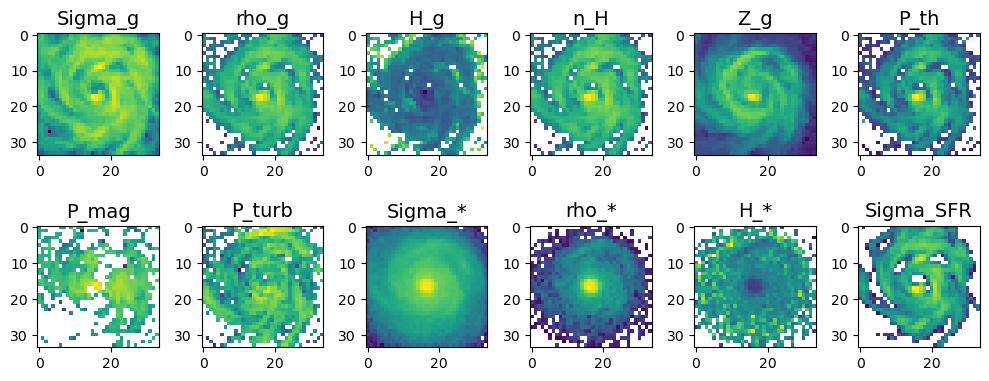

In [7]:
# display an example galaxy projection
fig, ax = plt.subplots(2, 6, figsize=(10, 4))
col_names = list(df.columns)
gal_ind = 606  # a good example; or np.random.randint(0,len(df))
ind = 0
for i in range(2):
    for j in range(6):
        ax[i, j].imshow(np.log10(df[col_names[1:][ind]].iloc[gal_ind]))
        ax[i, j].set_title(col_names[1:][ind], fontsize=14)
        ind += 1
plt.tight_layout()

### Self-consistent scale height and depletion time calculations using the PRFM theory and TIGRESS calibration

In [8]:
# flattening the data
Sigma_SFR = np.hstack([np.hstack(x) for x in df["Sigma_SFR"]])
rho_g = np.hstack([np.hstack(x) for x in df["rho_g"]])
rho_dm = np.hstack([np.hstack(x) for x in df["rho_dm"]])
Sigma_g = np.hstack([np.hstack(x) for x in df["Sigma_g"]])
Sigma_star = np.hstack([np.hstack(x) for x in df["Sigma_*"]])
H_star = np.hstack([np.hstack(x) for x in df["H_*"]])

# apply data mask to exclude bad pixels
data_mask = Sigma_g > 0
for var in [Sigma_g, Sigma_star, H_star, rho_dm]:
    data_mask &= np.isfinite(var)

Sigma_SFR = Sigma_SFR[data_mask]
rho_g = rho_g[data_mask]
rho_dm = rho_dm[data_mask]
Sigma_g = Sigma_g[data_mask]
Sigma_star = Sigma_star[data_mask]
H_star = H_star[data_mask]

# iterative solve for scale height
sigma_eff = 15.0  # initial guess; in km/s
for it in range(10):
    Hg_equil = get_Hg_equil(
        Sigma_g, Sigma_star, rho_dm, H_star, sigma_eff
    )  # scale height from vertical equalibrium in  kpc
    P_midplane = (
        Sigma_g
        * sigma_eff
        * sigma_eff
        / (2.0 * Hg_equil)
        * (Msun_per_gram / (kB * pc_per_cm * pc_per_cm * pc_per_cm / 10))
    )  # K/ cm^3

    # check error in velocity dispersion (using effective EOS)
    sigma_eff_next = 12.0 * (P_midplane * 1e-4) ** 0.22
    L1norm = np.std(sigma_eff_next - sigma_eff)
    print(it, L1norm)

    # update velocity dispersion
    sigma_eff = sigma_eff_next

# feedback yield from the TIGRESS-classic calibration (OK22)
Upsilon = 10.0 ** (-0.212 * np.log10(P_midplane) + 3.86)  # from TIGRESS simulations

# gas dynamical time (Gyr)
t_dyn = (2.0 * Hg_equil * (pc_per_cm / 100.0) / sigma_eff) * (1.0 / Year_per_sec) * 1e-9
# gas depletion times (Gyr)
t_dep_TNG50 = Sigma_g / Sigma_SFR * 1e-9  # depletion time from TNG50 in Gyr
t_dep_PRFM = Upsilon * t_dyn / sigma_eff  # depletion time from PRFM in Gyr

0 3.054212455265733
1 0.4242470487123917
2 0.07679528291118819
3 0.014373624109374062
4 0.002741791369511047
5 0.0005305981903175056
6 0.00010393022154046913
7 2.0570637775531342e-05
8 4.108454023286058e-06
9 8.269903679954028e-07


/var/folders/1_/qmv2ybq96d96qfc7r2xpfrr000014m/T/ipykernel_97539/129665065.py:49: RuntimeWarning: divide by zero encountered in divide
  t_dep_TNG50 = Sigma_g / Sigma_SFR * 1e-9  # depletion time from TNG50 in Gyr


### Reproduce Figure 9 in Hassan et al. 2024

In [9]:
def plot_tdyn_tdep(tdyn, tdep, weight, ax=None):
    if ax is None:
        ax = plt.gca()
    im = do_hist2d(
        np.log10(tdyn),
        np.log10(tdep),
        weight,
        ax,
        0.1,
        "auto",
        -5.0,
        5.0,
        -5.0,
        5.0,
        "hot_r",
    )

    # reference lines annd decorate axis
    x_tdyn = 10 ** np.linspace(-4, 4, 100)

    ax.set_xlim([-4, 0])
    ax.set_ylim([-3, 2])
    ax.grid(True)
    ax.tick_params(labelsize="large")
    ax.plot(
        np.log10(x_tdyn),
        np.log10(x_tdyn * 1.0),
        "g--",
        label=r"$t_{\rm dep}/t_{\rm dyn}=1$",
    )
    ax.plot(
        np.log10(x_tdyn),
        np.log10(x_tdyn * 10.0),
        "b--",
        label=r"$t_{\rm dep}/t_{\rm dyn}=10$",
    )
    ax.plot(
        np.log10(x_tdyn),
        np.log10(x_tdyn * (1 / 0.02)),
        "k-",
        label=r"$t_{\rm dep}/t_{\rm dyn}=50$",
    )
    ax.plot(
        np.log10(x_tdyn),
        np.log10(x_tdyn * 100.0),
        "r--",
        label=r"$t_{\rm dep}/t_{\rm dyn}=100$",
    )

    ax.set_ylabel(r"$\log_{10}\, t_{\rm dep}\, [\rm Gyr]$", fontsize="large")
    ax.set_xlabel(r"$\log_{10}\,  t_{\rm dyn}\, [\rm Gyr]$", fontsize="large")

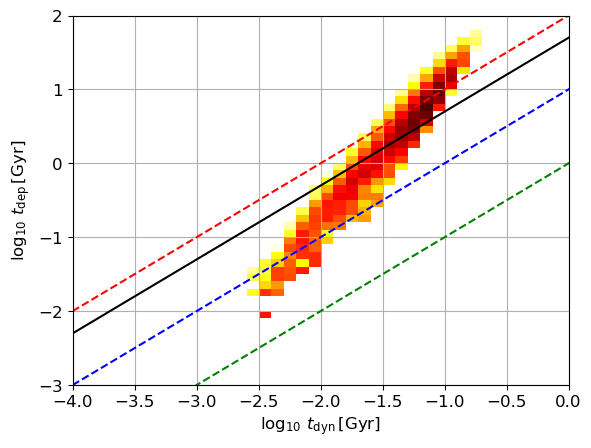

In [10]:
plot_tdyn_tdep(t_dyn, t_dep_PRFM, Sigma_SFR)

## Reproduce examples using the PRFM package

### Data reading (same as above)

In [11]:
# Retrieve data for redshift zero
redshift = 0
df = pd.read_pickle(f"../data/all_data_z{redshift}_selected.pkl")

# flattening the data
Sigma_SFR = np.hstack([np.hstack(x) for x in df["Sigma_SFR"]])
rho_g = np.hstack([np.hstack(x) for x in df["rho_g"]])
rho_dm = np.hstack([np.hstack(x) for x in df["rho_dm"]])
Sigma_g = np.hstack([np.hstack(x) for x in df["Sigma_g"]])
Sigma_star = np.hstack([np.hstack(x) for x in df["Sigma_*"]])
H_star = np.hstack([np.hstack(x) for x in df["H_*"]])
Z_g = np.hstack([np.hstack(x) for x in df["Z_g"]])

# apply data mask to exclude bad pixels
data_mask = Sigma_g > 0
for var in [Sigma_g, Sigma_star, H_star, rho_dm]:
    data_mask &= np.isfinite(var)

Sigma_SFR = Sigma_SFR[data_mask]
rho_g = rho_g[data_mask]
rho_dm = rho_dm[data_mask]
Sigma_g = Sigma_g[data_mask]
Sigma_star = Sigma_star[data_mask]
H_star = H_star[data_mask]
Z_g = Z_g[data_mask]

### PRFM class initialization

In [12]:
tng_prfm = prfm.PRFM(
    Sigma_gas=Sigma_g / 1.0e6,  # from M_sun/kpc^2 to M_sun/pc^2
    Sigma_star=Sigma_star / 1.0e6,  # from M_sun/kpc^2 to M_sun/pc^2
    H_star=H_star * 1.0e3,  # from kpc to pc
    rho_dm=rho_dm / 1.0e9,  # from M_sun/kpc^3 to M_sun/pc^3
    sigma_eff="tigress-classic-avg",
    Ytot="tigress-classic",
    astro_units=True,
)

In [13]:
tng_prfm

PRFM calculator is prepared for
  Sigma_gas[0]: 1.0845986138916015, N=107213
  Sigma_star[0]: 0.35946448046875, N=107213
  rho_star[0]: 0.00065556609375, N=107213
  Omega_d[0]: 14.179431180241075, N=107213
  rho_dm[0]: 0.003720031911502777, N=107213
  sigma_eff_model: tigress-classic-avg
  feedback_yield_model: tigress-classic

### Calculate scale height, SFR, gas depletion time

In [14]:
Hg = tng_prfm.calc_self_consistent_solution()

Calculating analytic H and weight solutions using the tigress-classic-avg effective EoS


In [15]:
sfr = tng_prfm.calc_sfr()

Calculating Sigma_SFR with the tigress-classic feedback yield model


In [16]:
tdyn, tdep = tng_prfm.calc_times()

### Reproduce Figure 9 in Hassan et al. 2024


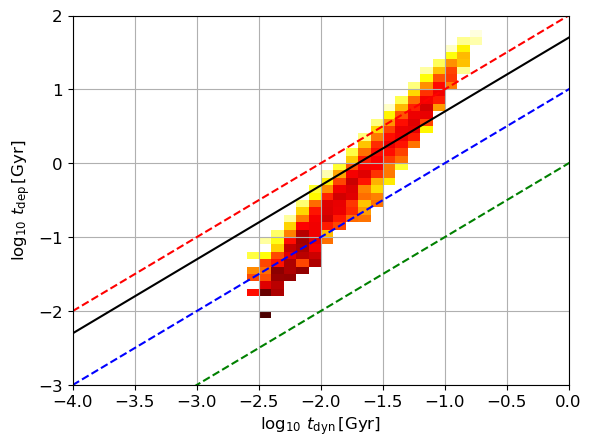

In [17]:
plot_tdyn_tdep(tdyn, tdep, sfr)

### Compare two solutions

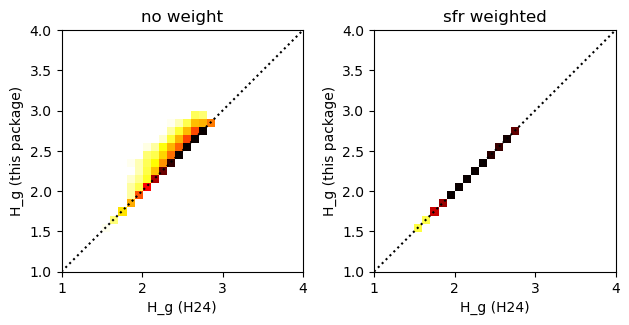

In [18]:
bin_width = 0.1
fig, axes = plt.subplots(1, 2)
ax = axes[0]
im = do_hist2d(
    np.log10(Hg_equil * 1.0e3),
    np.log10(Hg),
    np.ones_like(Sigma_SFR),
    ax,
    bin_width,
    "auto",
    1,
    4,
    1,
    4,
    "hot_r",
)
ax.set_title("no weight")

ax = axes[1]
im = do_hist2d(
    np.log10(Hg_equil * 1.0e3),
    np.log10(Hg),
    sfr,
    ax,
    bin_width,
    "auto",
    1,
    4,
    1,
    4,
    "hot_r",
)
ax.set_title("sfr weighted")

for ax in axes:
    plt.sca(ax)
    ref = np.linspace(1, 4)
    plt.plot(ref, ref, "k:")
    plt.xlabel("H_g (H24)")
    plt.ylabel("H_g (this package)")
    ax.set_aspect("equal")
plt.tight_layout()

## TIGRESS classic vs NCR

In [19]:
tng_prfm.set_sigma_eff("tigress-ncr-avg")
tng_prfm.set_feedback_yield("tigress-ncr-decomp")

In [20]:
Hg_ncr = tng_prfm.calc_self_consistent_solution()
sfr_ncr = tng_prfm.calc_sfr(Z=Z_g)
tdyn_ncr, tdep_ncr = tng_prfm.calc_times()

Calculating analytic H and weight solutions using the tigress-ncr-avg effective EoS
Calculating Sigma_SFR with the tigress-ncr-decomp feedback yield model
 also considering metallicity dependence!


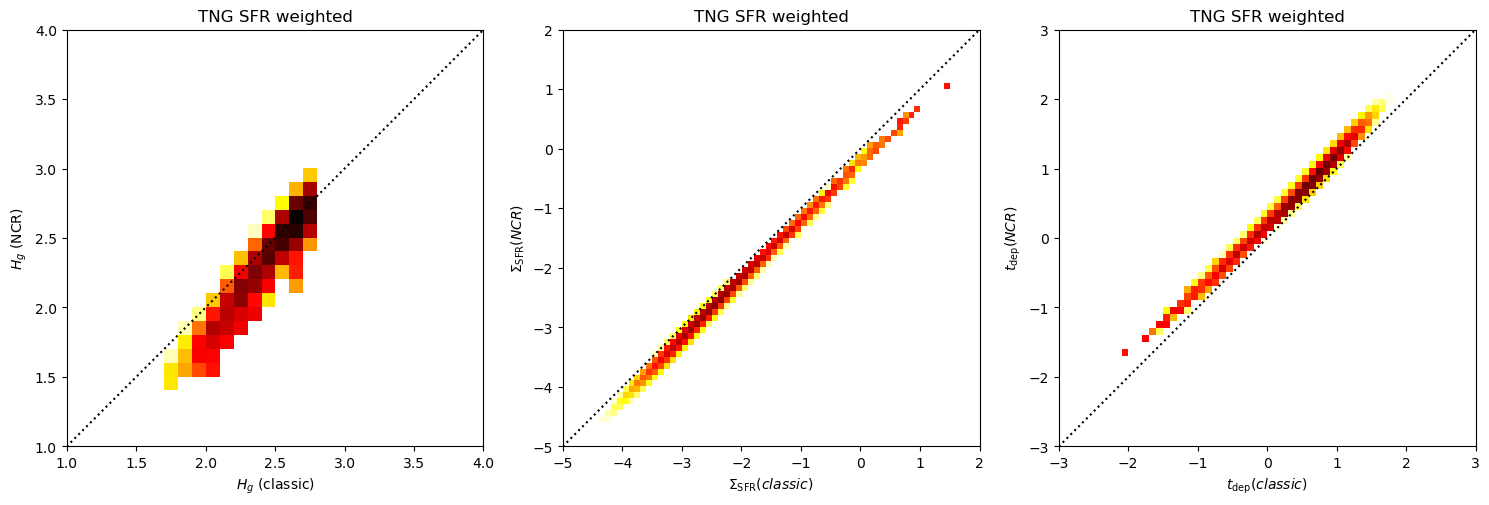

In [21]:
bin_width = 0.1
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Hgas
ax = axes[0]
im = do_hist2d(
    np.log10(Hg_equil * 1.0e3),
    np.log10(Hg_ncr),
    Sigma_SFR,
    ax,
    bin_width,
    "auto",
    1,
    4,
    1,
    4,
    "hot_r",
)
ax.set_title("TNG SFR weighted")

plt.sca(ax)
ref = np.linspace(1, 4)
plt.plot(ref, ref, "k:")
plt.xlabel(r"$H_g$ (classic)")
plt.ylabel(r"$H_g$ (NCR)")
ax.set_aspect("equal")

# Sigma_SFR
ax = axes[1]
im = do_hist2d(
    np.log10(sfr),
    np.log10(sfr_ncr),
    Sigma_SFR,
    ax,
    bin_width,
    "auto",
    -5,
    2,
    -5,
    2,
    "hot_r",
)
ax.set_title("TNG SFR weighted")


plt.sca(ax)
ref = np.linspace(-5, 2)
plt.plot(ref, ref, "k:")
plt.xlabel(r"$\Sigma_{\rm SFR} (classic)$")
plt.ylabel(r"$\Sigma_{\rm SFR} (NCR)$")
ax.set_aspect("equal")

# t_dep
ax = axes[2]
im = do_hist2d(
    np.log10(tdep),
    np.log10(tdep_ncr),
    Sigma_SFR,
    ax,
    bin_width,
    "auto",
    -3,
    3,
    -3,
    3,
    "hot_r",
)
ax.set_title("TNG SFR weighted")

plt.sca(ax)
ref = np.linspace(-3, 3)
plt.plot(ref, ref, "k:")
plt.xlabel(r"$t_{\rm dep} (classic)$")
plt.ylabel(r"$t_{\rm dep} (NCR)$")
ax.set_aspect("equal")
plt.tight_layout()

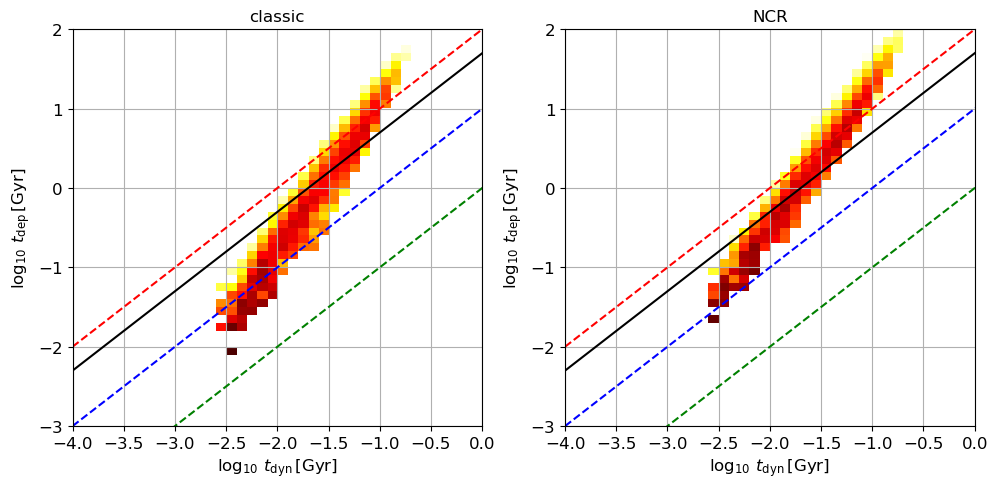

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axes[0])
plot_tdyn_tdep(tdyn, tdep, sfr)
plt.title("classic")
plt.sca(axes[1])
plot_tdyn_tdep(tdyn_ncr, tdep_ncr, sfr_ncr)
plt.title("NCR")
plt.tight_layout()